In [1]:
data_dir = '../../data/HRPO-E01240.1a/'

import json
import pandas as pd
from pathlib import Path 
import tbitk.data_manager as dm
import re

In [4]:
def get_meta(p):
    d = None
    if p.find('clarius-l7hd'):
        d = 'clarius-l7hd'
    if p.find('butterfly-iq'):
        d = 'butterfly-iq'

# r = r'ONUS-[\d]+HV'

def find_only(p, txt):
    m = re.search(p, txt)
    if m is not None:
        return m[0]
    else:
        return None

def rulers_to_list(j):
    if j: # j isn't an empty dict
        return [ (x['slice'], y['name'], y['points'], y['distance']) for x in j['rulers'] for y in x['rulers'] ]
    else:
        return []

def texts_to_list(j):
    if j:
        return [ (x['slice'], x['text']) for x in j['cornerTexts'] ]
    else:
        return []
    
def load_onsd(data_dir):
    ds = dm.posix_glob(f'{data_dir}/manual_onsd*')
    ans_r = []
    ans_txt = []
    for d in ds:
        r = r'manual_onsd-(?P<user>[^-]+)-(?P<replicate>[\d]+)'
        m = re.search(r, d)
        user = m.groupdict()['user']
        replicate = m.groupdict()['replicate']
        rulers = dm.posix_glob(f'{d}/**/*rulers.json', recursive=True)
        texts = dm.posix_glob(f'{d}/**/*cornerText.json', recursive=True)
        uns = [ r.replace('rulers', 'BASE') for r in rulers ] + [ t.replace('cornerText', 'BASE') for t in texts ]
        uns = set(uns)
        for u in uns:
            subject_id = find_only(r'ONUS-[\d]+HV', u)
            device = find_only(r'(clarius-l7hd)|(butterfly-iq)', u)
            # print('HERE', subject_id, device)
            r = u.replace('BASE', 'rulers')
            t = u.replace('BASE', 'cornerText')
            f = Path(u.replace('BASE.json', 'mha')).name
            if Path(r).exists():
                with open(r, 'rb') as fp1:
                    j = json.load(fp1)
                    tmp = rulers_to_list(j)
                    for x in range(len(tmp)):
                        ans_r.append((f, x, user, replicate, subject_id, device) + tmp[x])
            if Path(t).exists():
                with open(t, 'rb') as fp2:
                    j = json.load(fp2)
                    tmp = texts_to_list(j)
                    for x in range(len(tmp)):
                        ans_txt.append((f, x, user, replicate, subject_id, device) + tmp[x])
                
    df_rulers = pd.DataFrame(ans_r, columns=['filename', 'ruler_id', 'user', 'replicate', 'subject_id', 'device', 'frame', 'ruler_name', 'ruler_points', 'distance'])
    df_texts = pd.DataFrame(ans_txt, columns=['filename', 'text_id', 'user', 'replicate', 'subject_id', 'device', 'frame', 'text'])
    return df_rulers, df_texts


In [5]:
# note, there are one-to-many relationships between a video or image and the ruler and text annotations, with
# sometimes more than one ONSD ruler per video, or zero ONSDs.  similarly with text flags and transverse eye measurements.
df_rulers, df_texts = load_onsd(data_dir)
print(df_rulers, df_texts)

                                               filename  ruler_id  \
0     instance_data_37d916a6d4e6adde72eb40a5b6b14717...         0   
1     instance_data_37d916a6d4e6adde72eb40a5b6b14717...         1   
2                     capture_7_2022-06-27T09-05-21.mha         0   
3                     capture_7_2022-06-27T09-05-21.mha         1   
4                     capture_7_2022-06-27T09-05-21.mha         2   
...                                                 ...       ...   
1024                  capture_7_2022-06-27T15-59-19.mha         0   
1025                  capture_7_2022-06-27T15-59-19.mha         1   
1026  instance_data_b857f29d08ffb22651a109089ccd9b1b...         0   
1027  instance_data_b857f29d08ffb22651a109089ccd9b1b...         1   
1028  instance_data_b857f29d08ffb22651a109089ccd9b1b...         2   

                 user replicate  subject_id        device  frame ruler_name  \
0          Brad Moore         1  ONUS-029HV  butterfly-iq      0         R1   
1          Br

In [6]:
import pickle 
import itk

# used to clean up the raw meta-data-raw.csv and parse out subject ids, etc
# def get_video_or_image(x):
#     p = Path(x)
#     f = str(Path(data_dir) / Path('preprocessed') / p)
#     img = itk.imread(f)
#     ans = 'video' if img.ndim == 3 else 'image'
#     return ans
    
#     # load meta data to be later joined by subject_id and filename
# # this is a little breaky because we never insisted that filenames need to be unique (only entire relative paths)
# # but for clarius and butterfly the names are unique so this works
# df_meta = pd.read_csv(Path(data_dir) / Path('raw') / Path('meta-data-raw.csv'))
# df_meta['filename'] = df_meta.raw_path.map(lambda x: Path(x).name)
# df_meta['device'] = df_meta.raw_path.map(lambda x: Path(x).parts[1])
# df_meta['subject_id'] = df_meta.raw_path.map(lambda x: Path(x).parts[0])
# df_meta['type'] = df_meta.raw_path.map(lambda x: get_video_or_image(x))
# df_meta

# df_meta.to_csv(Path(data_dir) / Path('raw') / Path('meta-data.csv'))

In [4]:
df_meta = pd.read_csv(Path(data_dir) / Path('raw') / Path('meta-data.csv'))

In [6]:
df_meta['raw_path'][0]

'ONUS-001HV/butterfly-iq/left/1ed7e58ef41bbe2457a50c724cc1d367e995d475-0-burned_in.mha'

In [7]:
# TODO add filename fields so that Sean can determine which file these measurements belong to
# right now, we have to do the messy join on eye / subject
# resist the urge to average these measurements as we don't have a gold standard ONSD and averaging
# will lead to false confidence of the reliability of the measurement

df_clariusapp = pd.read_csv(Path(data_dir) / Path('clariusapp-annotations') / Path('clarius_app_annotations-Sean Montgomery.csv'))
df_clariusapp

,subject_id,eye,onsd_transverse_1,sheath_transverse_1,onsd_transverse_2,sheath_transverse_2,onsd_saggital_1,sheath_saggital_1,device
0,ONUS-001HV,right,4.09,NaN,NaN,NaN,NaN,NaN,clarius-l7hd
1,ONUS-001HV,left,4.36,NaN,NaN,NaN,NaN,NaN,clarius-l7hd
2,ONUS-002HV,right,4.95,NaN,NaN,NaN,NaN,NaN,clarius-l7hd
3,ONUS-002HV,left,2.63,NaN,NaN,NaN,NaN,NaN,clarius-l7hd
4,ONUS-003HV,right,4.45,NaN,NaN,y,NaN,NaN,clarius-l7hd
...,...,...,...,...,...,...,...,...,...
75,ONUS-038HV,left,5.32,n,NaN,NaN,4.52,y,clarius-l7hd
76,ONUS-039HV,right,4.79,n,NaN,NaN,4.92,y,clarius-l7hd
77,ONUS-039HV,left,3.93,n,NaN,NaN,4.31,y,clarius-l7hd
78,ONUS-040HV,right,3.36,y,NaN,NaN,4.26,y,clarius-l7hd


In [2]:
# df_rulers.to_csv('manual_onsd-rulers.csv')
# df_texts.to_csv('manual_onsd-texts.csv')
df_rulers = pd.read_csv('../../data/HRPO-E01240.1a/analysis_raw/manual_onsd-rulers-fixed.csv')
df_texts = pd.read_csv('../../data/HRPO-E01240.1a/analysis_raw/manual_onsd-texts-fixed.csv')

In [7]:
df_first = df_rulers.groupby(['filename', 'replicate', 'subject_id', 'device', 'ruler_name', 'user']).first().reset_index()
print(len(df_first))
df_first = pd.merge(df_first, df_meta, on=('filename', 'subject_id', 'device'))
print(len(df_first))
df_first_pivot = df_first.pivot(['filename', 'subject_id', 'ruler_name', 'replicate', 'device', 'type', 'eye', 'comment', 'orientation', 'raw_path'], columns=['user']).reset_index()
print(len(df_first_pivot))
df_first_pivot

976
976
638


filename  subject_id  \
user                                                                  
0                    capture_10_2022-06-24T10-37-19.mha  ONUS-028HV   
1                    capture_10_2022-06-24T10-37-19.mha  ONUS-028HV   
2                    capture_10_2022-06-24T10-37-19.mha  ONUS-028HV   
3                    capture_10_2022-06-24T11-32-06.mha  ONUS-028HV   
4                    capture_10_2022-06-24T11-32-06.mha  ONUS-028HV   
..                                                  ...         ...   
633   instance_data_f6e226c7e911b0c4063eaebf66ee95ca...  ONUS-032HV   
634   instance_data_f6e226c7e911b0c4063eaebf66ee95ca...  ONUS-032HV   
635   instance_data_fecde4d7ebb742e5c78e4399bdfeeba1...  ONUS-037HV   
636   instance_data_fecde4d7ebb742e5c78e4399bdfeeba1...  ONUS-037HV   
637   instance_data_fecde4d7ebb742e5c78e4399bdfeeba1...  ONUS-037HV   

     ruler_name replicate        device   type    eye comment orientation  \
user                                                                        
0             0         1  clarius-l7hd  video   left   sweep    sagittal   
1          ONSD         1  clarius-l7hd  video   left   sweep    sagittal   
2            R1         1  clarius-l7hd  video   left   sweep    sagittal   
3             0         1  clarius-l7hd  video   left   sweep  transverse   
4          ONSD         1  clarius-l7hd  video   left   sweep  transverse   
..          ...       ...           ...    ...    ...     ...         ...   
633        ONSD         1  butterfly-iq  image  right     NaN    sagittal   
634          R1         1  butterfly-iq  image  right     NaN    sagittal   
635           0         1  butterfly-iq  video   left     NaN    sagittal   
636        ONSD         1  butterfly-iq  video   left     NaN    sagittal   
637          R1         1  butterfly-iq  video   left     NaN    sagittal   

                                               raw_path  ...   ruler_id  \
user                                                     ... Brad Moore   
0     ONUS-028HV/clarius-l7hd/Both1/capture_10_2022-...  ...        2.0   
1     ONUS-028HV/clarius-l7hd/Both1/capture_10_2022-...  ...        1.0   
2     ONUS-028HV/clarius-l7hd/Both1/capture_10_2022-...  ...        0.0   
3     ONUS-028HV/clarius-l7hd/Both2/capture_10_2022-...  ...        2.0   
4     ONUS-028HV/clarius-l7hd/Both2/capture_10_2022-...  ...        1.0   
..                                                  ...  ...        ...   
633   ONUS-032HV/butterfly-iq/Both/instance_data_f6e...  ...        1.0   
634   ONUS-032HV/butterfly-iq/Both/instance_data_f6e...  ...        0.0   
635   ONUS-037HV/butterfly-iq/Both/instance_data_fec...  ...        2.0   
636   ONUS-037HV/butterfly-iq/Both/instance_data_fec...  ...        1.0   
637   ONUS-037HV/butterfly-iq/Both/instance_data_fec...  ...        0.0   

                          frame                  \
user Sean Montgomery Brad Moore Sean Montgomery   
0                NaN      511.0             NaN   
1                2.0      511.0           505.0   
2                3.0      511.0           505.0   
3                NaN      335.0             NaN   
4                1.0      335.0           445.0   
..               ...        ...             ...   
633              1.0        0.0             0.0   
634              0.0        0.0             0.0   
635              NaN      500.0             NaN   
636              1.0      500.0           507.0   
637              0.0      500.0           507.0   

                                           ruler_points  \
user                                         Brad Moore   
0     [[5.9067, 14.574, 21.2917], [29.7551, 16.8819,...   
1     [[16.1641, 28.977, 21.2917], [19.3695, 27.011,...   
2     [[16.1213, 25.4724, 21.2917], [17.5744, 28.122...   
3     [[10.2661, 17.6085, 13.9583], [36.6788, 12.394...   
4     [[21.5064, 27.3529, 13.9583], [24.7119, 29.062...   
..                                                  ...   
633   [[2

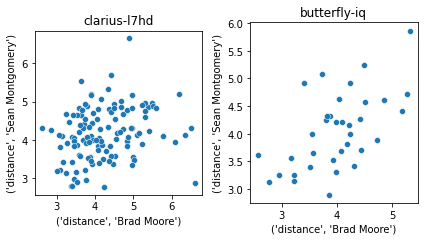

In [72]:
import seaborn as sb
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
sb.scatterplot(ax=axs[0], data=df_first_pivot[(df_first_pivot.ruler_name == 'ONSD') & (df_first_pivot.device == 'clarius-l7hd')], 
               x=('distance', 'Brad Moore'), 
               y=('distance', 'Sean Montgomery'))
axs[0].set_aspect('equal')
axs[0].set_title('clarius-l7hd')
sb.scatterplot(ax=axs[1], data=df_first_pivot[(df_first_pivot.ruler_name == 'ONSD') & (df_first_pivot.device == 'butterfly-iq')], 
               x=('distance', 'Brad Moore'), 
               y=('distance', 'Sean Montgomery'))
axs[1].set_title('butterfly-iq')
axs[1].set_aspect('equal')

fig.tight_layout()

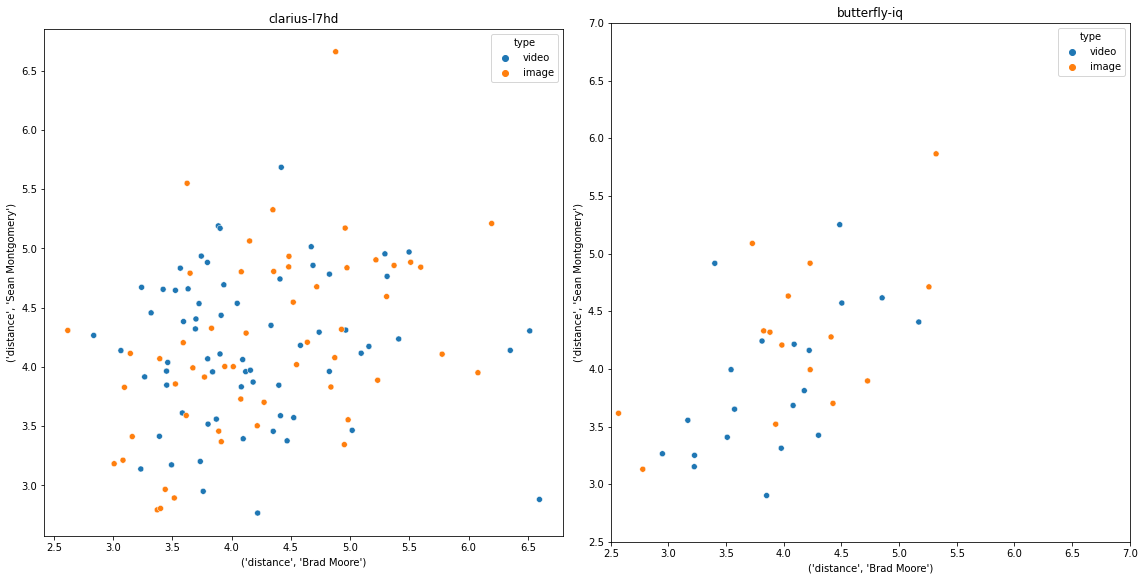

In [101]:
import seaborn as sb
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(16,16))
sb.scatterplot(ax=axs[0], data=df_first_pivot[(df_first_pivot.ruler_name == 'ONSD') & (df_first_pivot.device == 'clarius-l7hd')], 
               x=('distance', 'Brad Moore'), 
               y=('distance', 'Sean Montgomery'),
               hue='type')
axs[0].set_aspect('equal')
axs[0].set_title('clarius-l7hd')
sb.scatterplot(ax=axs[1], data=df_first_pivot[(df_first_pivot.ruler_name == 'ONSD') & (df_first_pivot.device == 'butterfly-iq')], 
               x=('distance', 'Brad Moore'), 
               y=('distance', 'Sean Montgomery'),
              hue='type')
axs[1].set_title('butterfly-iq')
axs[1].set_aspect('equal')

## TODO: make this data-driven
plt.xlim(2.5,7)
plt.ylim(2.5,7)
fig.tight_layout()

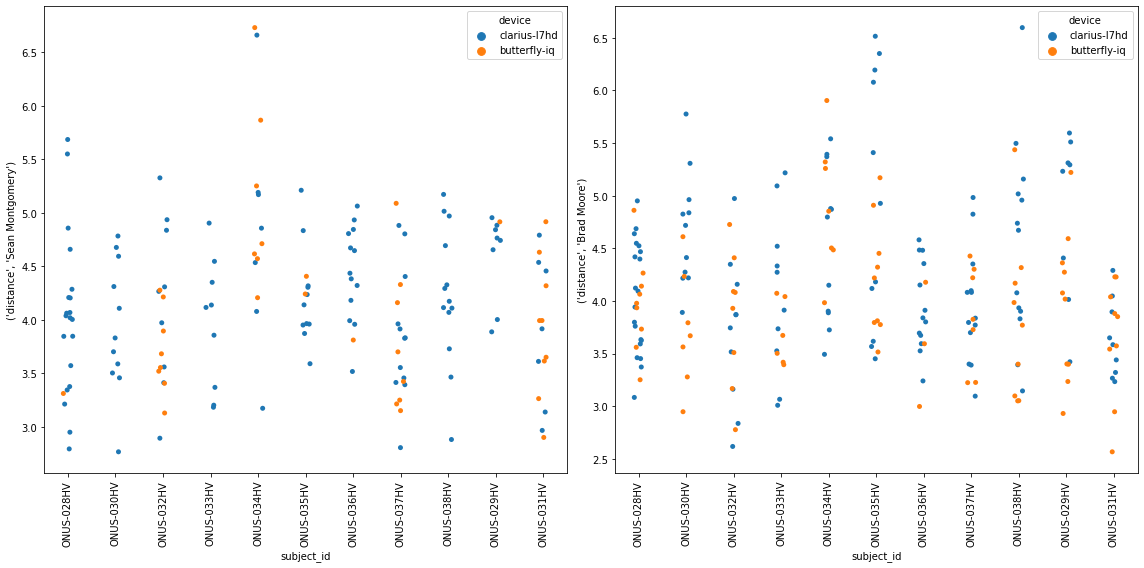

In [110]:
tmp = df_first_pivot[(df_first_pivot.ruler_name == 'ONSD')]

fig, axs = plt.subplots(1,2, figsize=(16,8))
g = sb.stripplot(ax=axs[0], data=tmp, hue='device', x='subject_id', y=('distance', 'Sean Montgomery'))
g.tick_params(axis='x', rotation=90)
g = sb.stripplot(ax=axs[1], data=tmp, hue='device', x='subject_id', y=('distance', 'Brad Moore'))
g.tick_params(axis='x', rotation=90)
fig.tight_layout()




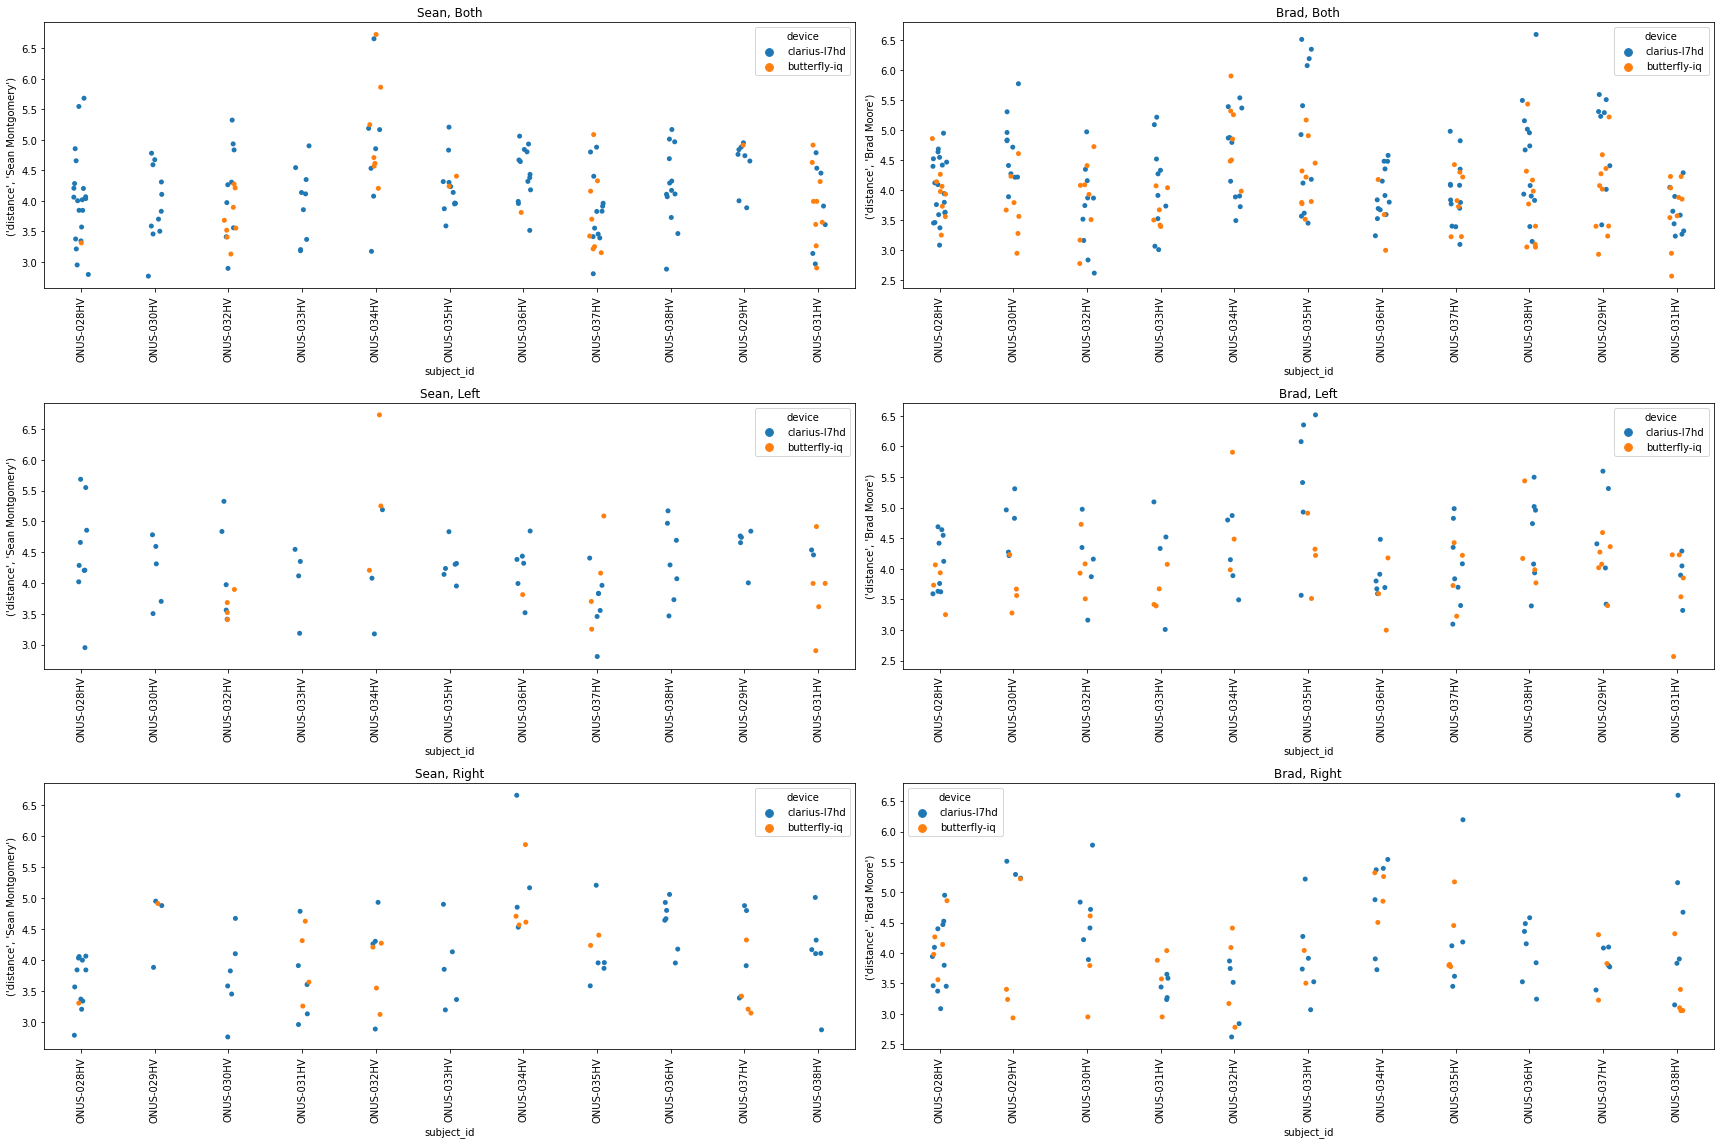

In [118]:
tmp = df_first_pivot[(df_first_pivot.ruler_name == 'ONSD')]

fig, axs = plt.subplots(3,2, figsize=(24,16))
g = sb.stripplot(ax=axs[0,0], data=tmp, hue='device', x='subject_id', y=('distance', 'Sean Montgomery'))
axs[0,0].set_title('Sean, Both')
g.tick_params(axis='x', rotation=90)
g = sb.stripplot(ax=axs[0,1], data=tmp, hue='device', x='subject_id', y=('distance', 'Brad Moore'))
axs[0,1].set_title('Brad, Both')
g.tick_params(axis='x', rotation=90)
g = sb.stripplot(ax=axs[1,0], data=tmp[tmp.eye == 'left'], hue='device', x='subject_id', y=('distance', 'Sean Montgomery'))
axs[1,0].set_title('Sean, Left')
g.tick_params(axis='x', rotation=90)
g = sb.stripplot(ax=axs[1,1], data=tmp[tmp.eye == 'left'], hue='device', x='subject_id', y=('distance', 'Brad Moore'))
axs[1,1].set_title('Brad, Left')
g.tick_params(axis='x', rotation=90)
g = sb.stripplot(ax=axs[2,0], data=tmp[tmp.eye == 'right'], hue='device', x='subject_id', y=('distance', 'Sean Montgomery'))
axs[2,0].set_title('Sean, Right')
g.tick_params(axis='x', rotation=90)
g = sb.stripplot(ax=axs[2,1], data=tmp[tmp.eye == 'right'], hue='device', x='subject_id', y=('distance', 'Brad Moore'))
axs[2,1].set_title('Brad, Right')
g.tick_params(axis='x', rotation=90)
fig.tight_layout()



In [11]:
from glob import glob 

df_alg = None
for f in glob('../../data/HRPO-E01240.1a/analysis_model_output/tables/*.csv'):
    df_alg = pd.read_csv(f) if df_alg is None else pd.concat((df_alg, pd.read_csv(f)), axis=0)

# df_alg = pd.read_csv('../../data/HRPO-E01240.1a/d383db/model_df_d383db.csv')
print(len(df_alg)) 
df_alg = pd.merge(df_alg, df_meta, on=['filename', 'device', 'subject_id'])

print(len(df_alg))
df_alg


FileNotFoundError: [Errno 2] No such file or directory: '../data/HRPO-E01240.1a/d383db/model_df_d383db.csv'

In [6]:
print(df_alg.groupby('device').count())
print(df_meta.groupby(['device']).count())


              filename  subject_id  sean_frame_num  model_onsd_sean_frame  \
device                                                                      
butterfly-iq        35          35              35                     31   
clarius-l7hd       122         122             122                    118   

              model_score_sean_frame  brad_frame_num  model_onsd_brad_frame  \
device                                                                        
butterfly-iq                      31              35                     30   
clarius-l7hd                     118             122                    117   

              model_score_brad_frame  model_onsd  Unnamed: 0  raw_path  eye  \
device                                                                        
butterfly-iq                      30          33          35        35   35   
clarius-l7hd                     117         121         122       122  122   

              orientation  comment  type  
device        

In [16]:
tmp = df_first_pivot[df_first_pivot.ruler_name == 'ONSD']
tmp = tmp[['subject_id', 'eye', 'orientation', 'device', 'distance']]
tmp.head()
tmp.groupby(['subject_id', 'eye', 'orientation', 'device']).describe()


distance                      \
user                                      Brad Moore                       
                                               count      mean       std   
subject_id eye   orientation device                                        
ONUS-028HV left  sagittal    butterfly-iq        2.0  3.999800  0.091500   
                             clarius-l7hd        2.0  4.199650  0.621335   
                 transverse  butterfly-iq        2.0  3.492050  0.340472   
                             clarius-l7hd        7.0  4.089286  0.474107   
           right sagittal    butterfly-iq        3.0  4.422433  0.385297   
...                                              ...       ...       ...   
ONUS-038HV left  transverse  clarius-l7hd        4.0  4.616850  0.741249   
           right sagittal    butterfly-iq        2.0  3.684900  0.894066   
                             clarius-l7hd        3.0  4.553500  0.671844   
                 transverse  butterfly-iq        3.0  3.182733  0.189596   
                             clarius-l7hd        3.0  4.548267  1.814496   

                                                                      \
user                                                                   
                                              min       25%      50%   
subject_id eye   orientation device                                    
ONUS-028HV left  sagittal    butterfly-iq  3.9351  3.967450  3.99980   
                             clarius-l7hd  3.7603  3.979975  4.19965   
                 transverse  butterfly-iq  3.2513  3.371675  3.49205   
                             clarius-l7hd  3.5919  3.628700  4.12220   
           right sagittal    butterfly-iq  4.1407  4.202900  4.26510   
...                                           ...       ...      ...   
ONUS-038HV left  transverse  clarius-l7hd  3.9344  4.041725  4.51785   
           right sagittal    butterfly-iq  3.0527  3.368800  3.68490   
                             clarius-l7hd  3.8304  4.251050  4.67170   
                 transverse  butterfly-iq  3.0508  3.074100  3.09740   
                             clarius-l7hd  3.1453  3.523700  3.90210   

                                                                             \
user                                                        Sean Montgomery   
                                                75%     max           count   
subject_id eye   orientation device                                           
ONUS-028HV left  sagittal    butterfly-iq  4.032150  4.0645             0.0   
                             clarius-l7hd  4.419325  4.6390             2.0   
                 transverse  butterfly-iq  3.612425  3.7328             0.0   
                             clarius-l7hd  4.483400  4.6867             7.0   
           right sagittal    butterfly-iq  4.563300  4.8615             0.0   
...                                             ...     ...             ...   
ONUS-038HV left  transverse  clarius-l7hd  5.092975  5.4973             4.0   
           right sagittal    butterfly-iq  4.001000  4.3171             0.0   
                             clarius-l7hd  4.915050  5.1584             3.0   
                 transverse  butterfly-iq  3.248700  3.4000             0.0   
                             clarius-l7hd  5.249750  6.5974             3.0   

                                                                       \
user                                                                    
                                               mean       std     min   
subject_id eye   orientation device                                     
ONUS-028HV left  sagittal    butterfly-iq       NaN       NaN     NaN   
                             clarius-l7hd  3.579200  0.889540  2.9502   
                 transverse  butterfly-iq       NaN       NaN     NaN   
                             clarius-l7hd  4.751171  0.655641  4.0192   
           right sagittal    butterfly-iq       NaN 

                          distance                                    
user                    Brad Moore           Sean Montgomery          
                              mean       mad            mean       mad
subject_id device                                                     
ONUS-028HV butterfly-iq   3.976556  0.317138        3.311800  0.000000
           clarius-l7hd   4.028465  0.456525        3.091675  0.142362
ONUS-029HV butterfly-iq   3.951000  0.567520        2.982600  0.000000
           clarius-l7hd   4.848562  0.675347        4.841600  0.000000
ONUS-030HV butterfly-iq   3.727886  0.415184             NaN       NaN
           clarius-l7hd   4.676509  0.430808        4.310900  0.000000
ONUS-031HV butterfly-iq   3.650867  0.438570        3.920244  0.500173
           clarius-l7hd   3.636478  0.297198             NaN       NaN
ONUS-032HV butterfly-iq   3.836588  0.513716        3.709788  0.314059
           clarius-l7hd   3.709600  0.541280        3.654600  0.611200
ONUS-0

dropping on a non-lexsorted multi-index without a level parameter may impact performance.


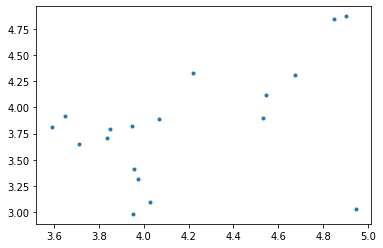

In [57]:
# OK start with by patient (combining both eyes)
tmp2 = tmp[['subject_id', 'device', 'distance']].groupby(['subject_id', 'device']).aggregate(['mean', 'mad'], axis=0)
print(tmp2)
# sb.scatterplot(data=tmp2, x=('distance', 'Brad Moore', 'mean'), y=('distance', 'Sean Montogomery', 'mean'))
import matplotlib.pyplot as plt
plt.plot(tmp2[('distance', 'Brad Moore', 'mean')], tmp2[('distance', 'Sean Montgomery', 'mean')], '.')

In [10]:
from statsmodels.formula.api import ols

tmp = df_first[df_first.ruler_name == 'ONSD']
m = ols('distance ~ subject_id + device + user', data=tmp)
r = m.fit()
print(r.summary())
type(m)

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     6.643
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           8.98e-11
Time:                        15:22:30   Log-Likelihood:                -375.55
No. Observations:                 370   AIC:                             777.1
Df Residuals:                     357   BIC:                             828.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

statsmodels.regression.linear_model.OLS

residual                                    \
                              count          mean       std       min   
type                                                                    
1                             370.0 -1.809964e-15  0.739489 -1.570886   
subject_id + device           370.0  1.440769e-14  0.668675 -1.735921   
subject_id + device + user    370.0  2.501302e-15  0.668596 -1.745998   

                                                                              \
                                 25%       50%       75%       95%       max   
type                                                                           
1                          -0.547111 -0.060786  0.468789  1.245709  2.592114   
subject_id + device        -0.481127 -0.036639  0.428598  1.093986  2.304572   
subject_id + device + user -0.493859 -0.043432  0.434897  1.102800  2.313513   

                           fitted_value                                    \
                                  count      mean           std       min   
type                                                                        
1                                 370.0  4.137586  8.893811e-16  4.137586   
subject_id + device               370.0  4.137586  3.157817e-01  3.666518   
subject_id + device + user        370.0  4.137586  3.159479e-01  3.658526   

                                                                              \
                                 25%       50%       75%       95%       max   
type                                                                           
1                           4.137586  4.137586  4.137586  4.137586  4.137586   
subject_id + device         3.958168  4.050292  4.292828  4.682980  4.909421   
subject_id + device + user  3.946012  4.061734  4.305059  4.697245  4.919498   

                            value                                        \
                            count      mean       std     min       25%   
type                                                                      
1                           370.0  4.137586  0.739489  2.5667  3.590475   
subject_id + device         370.0  4.137586  0.739489  2.5667  3.590475   
subject_id + device + user  370.0  4.137586  0.739489  2.5667  3.590475   

                                                                
                               50%       75%       95%     max  
type                                                            
1                           4.0768  4.606375  5.383295  6.7297  
subject_id + device         4.0768  4.606375  5.383295  6.7297  
subject_id + device + user  4.0768  4.606375  5.383295  6.7297

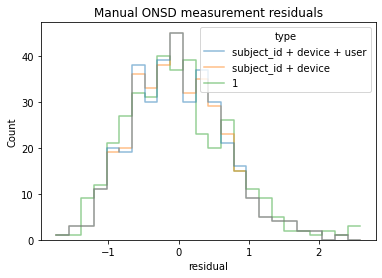

In [12]:
pd.set_option('display.max_columns', None)
import seaborn as sb
### series of regresssion to get the residuals, then we'll calculate mean residual, sd, and plot the histograms
### subject + device + user
### then breakout by user
###
tmp = df_first[df_first.ruler_name == 'ONSD']
m = ols('distance ~ subject_id + device + user', data=tmp)
r = m.fit()
df_ans = pd.DataFrame(columns=['residual', 'fitted_value', 'type'])
df_ans = pd.concat([df_ans, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['subject_id + device + user'] * len(r.resid) })], ignore_index=True)

m = ols('distance ~ subject_id + device', data=tmp)
r = m.fit()
df_ans = pd.concat([df_ans, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['subject_id + device'] * len(r.resid) })], ignore_index=True)

m = ols('distance ~ 1', data=tmp)
r = m.fit()
df_ans = pd.concat([df_ans, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['1'] * len(r.resid) })], ignore_index=True)


sb.histplot(data=df_ans, x='residual', hue='type', alpha=0.5, element="step", fill=False).set(title='Manual ONSD measurement residuals')
df_ans.groupby(['type']).describe(percentiles=[0.25, .5, .75, .95])

residual                                    \
                                    count          mean       std       min   
type                                                                          
1 (butterfly-iq)                    121.0  1.240514e-15  0.705350 -1.427034   
1 (clarius-l7hd)                    249.0 -3.317293e-16  0.746936 -1.589890   
subject_id + user (butterfly-iq)    121.0  5.960338e-15  0.578631 -1.170796   
subject_id + user (clarius-l7hd)    249.0  3.827371e-15  0.687721 -1.503448   

                                                                          \
                                       25%       50%       75%       95%   
type                                                                       
1 (butterfly-iq)                 -0.483834 -0.010134  0.327566  1.256866   
1 (clarius-l7hd)                 -0.534490 -0.091790  0.531110  1.254770   
subject_id + user (butterfly-iq) -0.449586 -0.010967  0.364632  0.961032   
subject_id + user (clarius-l7hd) -0.524993 -0.028390  0.466657  1.062980   

                                           fitted_value            \
                                       max        count      mean   
type                                                                
1 (butterfly-iq)                  2.735966        121.0  3.993734   
1 (clarius-l7hd)                  2.452110        249.0  4.207490   
subject_id + user (butterfly-iq)  1.663047        121.0  3.993734   
subject_id + user (clarius-l7hd)  2.178429        249.0  4.207490   

                                                                              \
                                           std       min       25%       50%   
type                                                                           
1 (butterfly-iq)                  0.000000e+00  3.993734  3.993734  3.993734   
1 (clarius-l7hd)                  8.899673e-16  4.207490  4.207490  4.207490   
subject_id + user (butterfly-iq)  4.033665e-01  3.620970  3.737496  3.833615   
subject_id + user (clarius-l7hd)  2.914679e-01  3.717443  3.979485  4.158563   

                                                                value  \
                                       75%       95%       max  count   
type                                                                    
1 (butterfly-iq)                  3.993734  3.993734  3.993734  121.0   
1 (clarius-l7hd)                  4.207490  4.207490  4.207490  249.0   
subject_id + user (butterfly-iq)  4.029935  5.066653  5.066653  121.0   
subject_id + user (clarius-l7hd)  4.418971  4.682890  4.756848  249.0   

                                                                              \
                                      mean       std     min     25%     50%   
type                                                                           
1 (butterfly-iq)                  3.993734  0.705350  2.5667  3.5099  3.9836   
1 (clarius-l7hd)                  4.207490  0.746936  2.6176  3.6730  4.1157   
subject_id + user (butterfly-iq)  3.993734  0.705350  2.5667  3.5099  3.9836   
subject_id + user (clarius-l7hd)  4.207490  0.746936  2.6176  3.6730  4.1157   

                                                           
                                     75%      95%     max  
type                                                       
1 (butterfly-iq)                  4.3213  5.25060  6.7297  
1 (clarius-l7hd)                  4.7386  5.46226  6.6596  
subject_id + user (butterfly-iq)  4.3213  5.25060  6.7297  
subject_id + user (clarius-l7hd)  4.7386  5.46226  6.6596

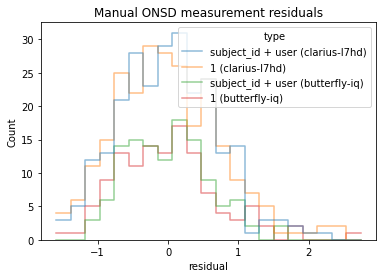

In [39]:
tmp = df_first[(df_first.ruler_name == 'ONSD') & (df_first.device == 'clarius-l7hd')]
m = ols('distance ~ subject_id + user', data=tmp)
r = m.fit()

df_ans = pd.DataFrame(columns=['residual', 'fitted_value', 'type'])
df_ans = pd.concat([df_ans, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['subject_id + user (clarius-l7hd)'] * len(r.resid) })], ignore_index=True)

m = ols('distance ~ 1', data=tmp)
r = m.fit()
df_ans = pd.concat([df_ans, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['1 (clarius-l7hd)'] * len(r.resid) })], ignore_index=True)

tmp = df_first[(df_first.ruler_name == 'ONSD') & (df_first.device == 'butterfly-iq')]
m = ols('distance ~ subject_id + user', data=tmp)
r = m.fit()
df_ans = pd.concat([df_ans, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['subject_id + user (butterfly-iq)'] * len(r.resid) })], ignore_index=True)

m = ols('distance ~ 1', data=tmp)
r = m.fit()
df_ans = pd.concat([df_ans, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['1 (butterfly-iq)'] * len(r.resid) })], ignore_index=True)


sb.histplot(data=df_ans, x='residual', hue='type', alpha=0.5, element="step", fill=False).set(title='Manual ONSD measurement residuals')
df_ans.groupby(['type']).describe(percentiles=[0.25, .5, .75, .95])

residual                                              \
                       count          mean       std       min       25%   
type                                                                       
1                      154.0  1.355337e-16  1.053833 -2.551395 -0.565958   
subject_id + device    154.0  9.798800e-15  0.998485 -2.665466 -0.550872   

                                                            fitted_value  \
                          50%       75%       95%       max        count   
type                                                                       
1                    0.012839  0.517233  1.896256  4.469558        154.0   
subject_id + device -0.024761  0.533740  1.800006  4.285694        154.0   

                                                                           \
                         mean           std       min       25%       50%   
type                                                                        
1                    4.757109  8.910762e-16  4.757109  4.757109  4.757109   
subject_id + device  4.757109  3.370347e-01  4.170747  4.521438  4.659206   

                                                   value                      \
                          75%       95%       max  count      mean       std   
type                                                                           
1                    4.757109  4.757109  4.757109  154.0  4.757109  1.053833   
subject_id + device  5.053758  5.385466  5.524456  154.0  4.757109  1.053833   

                                                                       \
                          min       25%       50%       75%       95%   
type                                                                    
1                    2.205714  4.191151  4.769948  5.274342  6.653365   
subject_id + device  2.205714  4.191151  4.769948  5.274342  6.653365   

                               
                          max  
type                           
1                    9.226667  
subject_id + device  9.226667

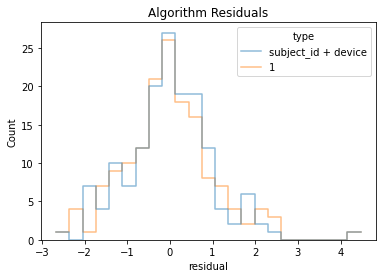

In [17]:
df_ans2 = pd.DataFrame(columns=['residual', 'fitted_value', 'type'])
m = ols('model_onsd ~ subject_id + device', data=df_alg)
r = m.fit()
df_ans2 = pd.concat([df_ans2, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['subject_id + device'] * len(r.resid) })], ignore_index=True)

m = ols('model_onsd ~ 1', data=df_alg)
r = m.fit()
df_ans2 = pd.concat([df_ans2, pd.DataFrame({ 'residual' : r.resid, 'fitted_value' : r.fittedvalues, 'value' : r.resid + r.fittedvalues, 'type' : ['1'] * len(r.resid) })], ignore_index=True)
sb.histplot(data=df_ans2, x='residual', hue='type', alpha=0.5, element="step", fill=False).set(title='Algorithm Residuals')
df_ans2.groupby(['type']).describe(percentiles=[0.25, .5, .75, .95])


In [32]:


tmp = df_rulers[(df_rulers.ruler_name == 'ONSD') & (df_rulers.user == 'Brad Moore')]
tmp = tmp[['filename', 'frame', 'distance']]
tmp.rename({'frame' : 'brad_frame_num', 'distance' : 'brad_onsd'} ,axis=1, inplace=True)

df_alg2 = pd.merge(df_alg, tmp, on=['filename', 'brad_frame_num'])

tmp = df_rulers[(df_rulers.ruler_name == 'ONSD') & (df_rulers.user == 'Sean Montgomery')]
tmp = tmp[['filename', 'frame', 'distance']]
tmp.rename({'frame' : 'sean_frame_num', 'distance' : 'sean_onsd'} ,axis=1, inplace=True)

df_alg2 = pd.merge(df_alg, tmp, on=['filename', 'sean_frame_num'])

ans = pd.DataFrame({'filename' : df_alg2.filename, 'brad_sean' : df_alg2.brad_onsd - df_alg2.sean_onsd, 'brad_model' : df_alg2., 'sean_model', 'type'}

,filename,device,subject_id,sean_frame_num,model_onsd_sean_frame,model_score_sean_frame,brad_frame_num,model_onsd_brad_frame,model_score_brad_frame,model_onsd,Unnamed: 0,raw_path,eye,orientation,comment,type,sean_onsd
0,instance_data_0176ee777c4dff663a3270bb81877c1f...,butterfly-iq,ONUS-032HV,113,3.480000,0.163399,110,3.000000,0.187909,4.247778,572,ONUS-032HV/butterfly-iq/Both/instance_data_017...,right,sagittal,NaN,video,4.2135
1,instance_data_061a58c373e0dce349a62462178cad7e...,butterfly-iq,ONUS-034HV,0,5.213333,0.147059,0,5.213333,0.147059,5.213333,608,ONUS-034HV/butterfly-iq/Both/instance_data_061...,right,sagittal,NaN,image,4.7111
2,instance_data_17c80b61b6b5a14215109a98fd0127b7...,butterfly-iq,ONUS-035HV,455,4.973333,0.228758,454,4.600000,0.228758,4.809825,629,ONUS-035HV/butterfly-iq/Both/instance_data_17c...,right,transverse,NaN,video,4.2414
3,instance_data_1f837ebae0c4d0c20fe92c4b0cb9534c...,butterfly-iq,ONUS-031HV,0,4.266667,0.098039,0,4.266667,0.098039,4.266667,554,ONUS-031HV/butterfly-iq/Both/instance_data_1f8...,right,transverse,NaN,image,4.6315
4,instance_data_224af6db73205958d94d4dd3075b9de2...,butterfly-iq,ONUS-034HV,405,4.440000,0.163399,411,4.080000,0.138889,4.832381,609,ONUS-034HV/butterfly-iq/Both/instance_data_224...,right,sagittal,NaN,video,4.5710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,capture_9_2022-06-27T10-18-29.mha,clarius-l7hd,ONUS-032HV,0,5.146667,0.002307,0,5.146667,0.002307,5.146667,589,ONUS-032HV/clarius-l7hd/Both/capture_9_2022-06...,left,sagittal,NaN,image,4.8366
151,capture_9_2022-06-27T11-50-53.mha,clarius-l7hd,ONUS-033HV,0,4.653333,0.001217,0,4.653333,0.001217,4.653333,606,ONUS-033HV/clarius-l7hd/Both/capture_9_2022-06...,left,sagittal,NaN,image,4.5462
152,capture_9_2022-06-27T14-22-57.mha,clarius-l7hd,ONUS-035HV,0,5.200000,0.001346,0,5.200000,0.001346,5.200000,648,ONUS-035HV/clarius-l7hd/Both/capture_9_2022-06...,left,sagittal,NaN,image,4.3173
153,capture_9_2022-06-27T15-31-28.mha,clarius-l7hd,ONUS-036HV,702,4.386667,0.531046,580,4.746667,0.334967,4.768696,665,ONUS-036HV/clarius-l7hd/Both/capture_9_2022-06...,left,transverse,NaN,video,4.3828


,sean_frame_num,model_onsd_sean_frame,model_score_sean_frame,brad_frame_num,model_onsd_brad_frame,model_score_brad_frame,model_onsd,Unnamed: 0
count,157.000000,149.000000,149.000000,157.000000,147.000000,147.000000,154.000000,157.000000
mean,187.038217,4.939060,0.216867,204.694268,4.940499,0.223876,4.757109,600.853503
std,225.783334,1.064772,0.206208,237.634973,1.169835,0.216231,1.053833,63.343773
min,0.000000,2.426667,0.000481,0.000000,1.906667,0.000481,2.205714,491.000000
25%,0.000000,4.373333,0.001986,0.000000,4.280000,0.001970,4.191151,552.000000
50%,93.000000,4.866667,0.196078,110.000000,4.933333,0.212418,4.769948,600.000000
75%,355.000000,5.560000,0.375817,426.000000,5.633333,0.359477,5.274342,658.000000
max,720.000000,7.440000,0.825163,721.000000,7.773333,0.866013,9.226667,708.000000


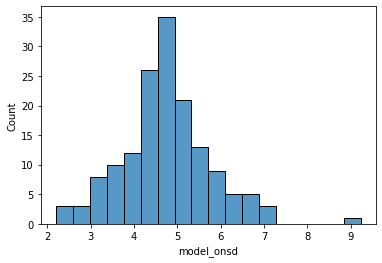

In [18]:
sb.histplot(data=df_alg, x='model_onsd')
df_alg.describe()

In [112]:
m2 = ols('model_onsd ~ device + subject_id', data=df_alg)
r2 = m2.fit()
print(r2.summary())

                            OLS Regression Results                            
Dep. Variable:             model_onsd   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.471
Date:                Tue, 11 Apr 2023   Prob (F-statistic):              0.149
Time:                        12:54:10   Log-Likelihood:                -217.78
No. Observations:                 154   AIC:                             459.6
Df Residuals:                     142   BIC:                             496.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [69]:
import numpy as np

tmp = df_first[df_first.ruler_name == 'ONSD']
print('subject_id, device, user: ', np.mean(tmp.groupby(['subject_id', 'device', 'user']).aggregate({ 'distance' : 'mad' })['distance']))
print('subject_id, device: ', np.mean(tmp.groupby(['subject_id', 'user']).aggregate({ 'distance' : 'mad' })['distance']))
print('subject_id, device, user: ', np.mean(tmp.groupby(['subject_id', 'device', 'user']).aggregate({ 'distance' : 'mad' })['distance']))

subject_id, device, user:  0.4314390400344343
subject_id, device:  0.5234725953597361
subject_id, device, user:  0.4314390400344343


In [51]:
print(tmp2[('distance', 'Sean Montgomery', 'mean')])

subject_id  device      
ONUS-028HV  butterfly-iq    3.311800
            clarius-l7hd    3.091675
ONUS-029HV  butterfly-iq    2.982600
            clarius-l7hd    4.841600
ONUS-030HV  butterfly-iq         NaN
            clarius-l7hd    4.310900
ONUS-031HV  butterfly-iq    3.920244
            clarius-l7hd         NaN
ONUS-032HV  butterfly-iq    3.709788
            clarius-l7hd    3.654600
ONUS-033HV  butterfly-iq         NaN
            clarius-l7hd    3.889533
ONUS-034HV  butterfly-iq    4.870033
            clarius-l7hd    4.120200
ONUS-035HV  butterfly-iq    4.323900
            clarius-l7hd    3.027150
ONUS-036HV  butterfly-iq    3.811100
            clarius-l7hd    3.819650
ONUS-037HV  butterfly-iq    3.789813
            clarius-l7hd    3.409900
ONUS-038HV  butterfly-iq         NaN
            clarius-l7hd    3.894771
Name: (distance, Sean Montgomery, mean), dtype: float64


In [43]:
import itk
from ipywidgets import interact
from glob import glob
import matplotlib.pyplot as plt
@interact(x=(0, len(df_alg)-1, 1))
def foo(x=0):
    z = df_alg.iloc[x]
    print(z)
    z = z.filename.replace('.mha', '_plot.png')
    img = itk.imread(glob(f'../../data/HRPO-E01240.1a/analysis_model_output/images/annotation_check*/**/{z}', recursive=True)[0])
    fig, ax = plt.subplots(1,1,figsize=(16,16))
    plt.imshow(img)
    # img = itk.imread(glob(f'../../data/HRPO-E01240.1a/d383db/annotation_check/**/{z.filename[0]}', recursive=True))

interactive(children=(IntSlider(value=0, description='x', max=156), Output()), _dom_classes=('widget-interact'…

In [153]:
tmp1 = df_alg[df_alg.type == 'image']
tmp2 = df_alg[df_alg.type == 'video']
print('images only')
print(tmp1[['type', 'model_onsd_sean_frame', 'model_onsd_brad_frame']].corr())
print('video only')
print(tmp2[['type', 'model_onsd_sean_frame', 'model_onsd_brad_frame', 'model_onsd']].corr())

images only
                       model_onsd_sean_frame  model_onsd_brad_frame
model_onsd_sean_frame                    1.0                    1.0
model_onsd_brad_frame                    1.0                    1.0
video only
                       model_onsd_sean_frame  model_onsd_brad_frame  \
model_onsd_sean_frame               1.000000               0.122542   
model_onsd_brad_frame               0.122542               1.000000   
model_onsd                          0.596793              -0.118919   

                       model_onsd  
model_onsd_sean_frame    0.596793  
model_onsd_brad_frame   -0.118919  
model_onsd               1.000000  


In [165]:
tmp3 = df_alg.copy()
tmp1 = df_rulers[(df_rulers.user == 'Sean Montgomery') & (df_rulers.ruler_name == 'ONSD')].copy()
tmp1.rename({ 'frame' : 'sean_frame_num', 'distance' : 'sean_onsd' }, axis=1, inplace=True)
tmp1 = tmp1[['filename', 'sean_frame_num', 'sean_onsd']]
tmp3 = pd.merge(tmp3, tmp1, on=['filename', 'sean_frame_num'])

tmp1 = df_rulers[(df_rulers.user == 'Brad Moore') & (df_rulers.ruler_name == 'ONSD')].copy()
tmp1.rename({ 'frame' : 'brad_frame_num', 'distance' : 'brad_onsd' }, axis=1, inplace=True)
tmp1 = tmp1[['filename', 'brad_frame_num', 'brad_onsd']]
tmp3 = pd.merge(tmp3, tmp1, on=['filename', 'brad_frame_num'])
tmp3

tmp1 = tmp3[tmp3.type == 'image']
tmp1 = tmp1[['model_onsd', 'brad_onsd', 'sean_onsd']]

tmp2 = tmp3[tmp3.type == 'video']
tmp2 = tmp2[['model_onsd', 'model_onsd_sean_frame', 'model_onsd_brad_frame', 'brad_onsd', 'sean_onsd']]
print('images only')
print(tmp1.corr())
print('video only')
print(tmp2.corr())

images only
            model_onsd  brad_onsd  sean_onsd
model_onsd    1.000000   0.301564   0.204957
brad_onsd     0.301564   1.000000   0.599221
sean_onsd     0.204957   0.599221   1.000000
video only
                       model_onsd  model_onsd_sean_frame  \
model_onsd               1.000000               0.596793   
model_onsd_sean_frame    0.596793               1.000000   
model_onsd_brad_frame   -0.118919               0.122542   
brad_onsd                0.252991               0.171904   
sean_onsd                0.019721               0.141777   

                       model_onsd_brad_frame  brad_onsd  sean_onsd  
model_onsd                         -0.118919   0.252991   0.019721  
model_onsd_sean_frame               0.122542   0.171904   0.141777  
model_onsd_brad_frame               1.000000  -0.199808   0.069619  
brad_onsd                          -0.199808   1.000000   0.443839  
sean_onsd                           0.069619   0.443839   1.000000  


               distance_brad  distance_sean
distance_brad       1.000000       0.609361
distance_sean       0.609361       1.000000
0.48659729729729734 0.6743324324324323


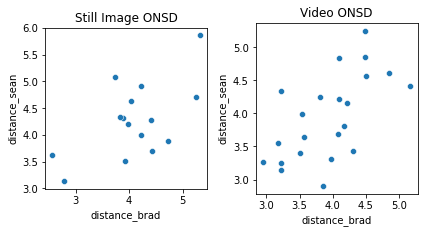

In [198]:
tmp = pd.merge(df_rulers, df_meta, on=['filename', 'subject_id', 'device'])
tmp = tmp[(tmp.device == 'butterfly-iq') & (tmp.ruler_name == 'ONSD')]
tmp1 = tmp[trecursive.user == 'Brad Moore']
tmp2 = tmp[tmp.user == 'Sean Montgomery']
tmp3 = pd.merge(tmp1, tmp2, on=['filename', 'subject_id', 'device', 'orientation', 'type'], suffixes=['_brad', '_sean'])
tmp3 = tmp3[(tmp3.distance_brad < 10) & (tmp3.distance_sean < 10)]

fig, axs = plt.subplots(1,2)
g1=sb.scatterplot(ax=axs[0], data=tmp3[tmp3.type == 'image'], x='distance_brad', y='distance_sean')
g1.set_aspect('equal')
axs[0].set_title('Still Image ONSD')
g2=sb.scatterplot(ax=axs[1], data=tmp3[tmp3.type == 'video'], x='distance_brad', y='distance_sean')
g2.set_aspect('equal')
axs[1].set_title('Video ONSD')

fig.tight_layout()

print(tmp3[['distance_brad', 'distance_sean']].corr())


tmp4 = pd.DataFrame( { 'x' : tmp3.sample(frac=1, random_state=324789, ignore_index=True).distance_brad, 'y' : tmp3.sample(frac=1, random_state=123124,  ignore_index=True).distance_sean}, index=pd.RangeIndex(0, len(tmp3)) )
print(np.mean(np.abs(tmp3.distance_brad - tmp3.distance_sean)), np.mean(np.abs(tmp4.x - tmp4.y)))
# cols = ['filename', 'subject_id', '
# tmp3 = 
# tmp3 = pd.merge(tmp1, tmp2, on=['subject_id', 'eye', 'orientation']

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

tmp = df_rulers[(df_rulers.ruler_name == 'ONSD') & (df_rulers.distance < 10) & (df_rulers.user == 'Brad Moore') & (df_rulers.device == 'butterfly-iq')]
model = smf.ols('distance ~ subject_id + 0', data=tmp)

res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     3.069
Date:                Fri, 10 Feb 2023   Prob (F-statistic):            0.00405
Time:                        15:50:02   Log-Likelihood:                -59.387
No. Observations:                  74   AIC:                             138.8
Df Residuals:                      64   BIC:                             161.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
subject_id[ONUS-028HV]     3.9766      0.194     20.550      0.000       3.590       4.363
subject_id[ONUS-030HV]     3.7279      0.219     16.990      0.000       3.290       4.166
subject_id[ONUS-031HV]     3.6509      0.194     18.867      0.000       3.264       4.037
subject_id[ONUS-032HV]     3.8366      0.205     18.692      0.000       3.427       4.247
subject_id[ONUS-033HV]     3.6837      0.237     15.543      0.000       3.210       4.157
subject_id[ONUS-034HV]     4.9015      0.219     22.338      0.000       4.463       5.340
subject_id[ONUS-035HV]     4.2189      0.194     21.802      0.000       3.832       4.605
subject_id[ONUS-036HV]     3.5896      0.335     10.710      0.000       2.920       4.259
subject_id[ONUS-037HV]     3.8502      0.219     17.547      0.000       3.412       4.289
subject_id[ONUS-038HV]     3.8088      0.194     19.683      0.000       3.422       4.195
==============================================================================
Omnibus:                        0.774   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.679   Jarque-Bera (JB):                0.696
Skew:                           0.231   Prob(JB):                        0.706
Kurtosis:                       2.887   Cond. No.                         1.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

tmp = df_rulers[(df_rulers.ruler_name == 'ONSD') & (df_rulers.distance < 10) & (df_rulers.user == 'Brad Moore') & (df_rulers.device == 'clarius-l7hd')]
model = smf.ols('distance ~ subject_id + 0', data=tmp)

res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     4.206
Date:                Fri, 10 Feb 2023   Prob (F-statistic):           0.000106
Time:                        15:50:17   Log-Likelihood:                -124.80
No. Observations:                 121   AIC:                             269.6
Df Residuals:                     111   BIC:                             297.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
subject_id[ONUS-028HV]     4.0285      0.158     25.423      0.000       3.714       4.342
subject_id[ONUS-030HV]     4.6765      0.214     21.887      0.000       4.253       5.100
subject_id[ONUS-031HV]     3.6365      0.236     15.395      0.000       3.168       4.105
subject_id[ONUS-032HV]     3.7096      0.224     16.554      0.000       3.266       4.154
subject_id[ONUS-033HV]     4.0685      0.224     18.155      0.000       3.624       4.513
subject_id[ONUS-034HV]     4.5463      0.214     21.278      0.000       4.123       4.970
subject_id[ONUS-035HV]     4.9465      0.214     23.151      0.000       4.523       5.370
subject_id[ONUS-036HV]     3.9487      0.197     20.091      0.000       3.559       4.338
subject_id[ONUS-037HV]     3.9546      0.197     20.121      0.000       3.565       4.344
subject_id[ONUS-038HV]     4.5325      0.197     23.061      0.000       4.143       4.922
==============================================================================
Omnibus:                        1.068   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.586   Jarque-Bera (JB):                1.045
Skew:                           0.220   Prob(JB):                        0.593
Kurtosis:                       2.887   Cond. No.                         1.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
tmp = df_rulers[(df_rulers.ruler_name == 'ONSD') & (df_rulers.distance < 10) & (df_rulers.user == 'Brad Moore')]
tmp2 = tmp.groupby(by=['subject_id', 'device'], as_index='False').agg({'distance' : ['mean', 'std']})
tmp2.unstack()

distance                                       
                   mean                       std             
device     butterfly-iq clarius-l7hd butterfly-iq clarius-l7hd
subject_id                                                    
ONUS-028HV     3.976556     4.028465     0.455768     0.527562
ONUS-030HV     3.727886     4.676509     0.559832     0.548592
ONUS-031HV     3.650867     3.636478     0.570003     0.371530
ONUS-032HV     3.836588     3.709600     0.646995     0.711154
ONUS-033HV     3.683667     4.068490     0.305619     0.763306
ONUS-034HV     4.901486     4.546309     0.643762     0.738473
ONUS-035HV     4.218878     4.946464     0.557371     1.211015
ONUS-036HV     3.589633     3.948685     0.590110     0.424108
ONUS-037HV     3.850243     3.954592     0.495152     0.542022
ONUS-038HV     3.808800     4.532500     0.781887     0.946074

[[1.         0.48715262]
 [0.48715262 1.        ]]


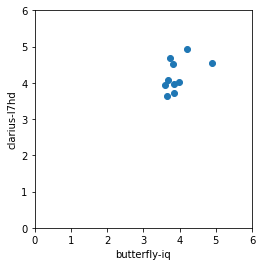

In [42]:
import matplotlib.pyplot as plt
import numpy as np
tmp3 = tmp2.unstack()
tmp3['distance', 'mean']
x = tmp3['distance', 'mean', 'butterfly-iq']
y = tmp3['distance', 'mean', 'clarius-l7hd']
print(np.corrcoef(x, y))
fig, ax = plt.subplots(1,1)
ax.scatter(x, y)
plt.xlabel('butterfly-iq')
plt.ylabel('clarius-l7hd')
plt.xlim((0,6))
plt.ylim((0,6))
ax.set_aspect('equal', adjustable='box')

[[1.         0.20001445]
 [0.20001445 1.        ]]


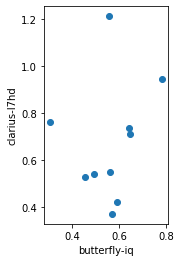

In [45]:
import matplotlib.pyplot as plt
import numpy as np
tmp3 = tmp2.unstack()
tmp3['distance', 'std']
x = tmp3['distance', 'std', 'butterfly-iq']
y = tmp3['distance', 'std', 'clarius-l7hd']
print(np.corrcoef(x, y))
fig, ax = plt.subplots(1,1)
ax.scatter(x, y)
plt.xlabel('butterfly-iq')
plt.ylabel('clarius-l7hd')
ax.set_aspect('equal', adjustable='box')

In [35]:
r = r'ONUS-[\d]+HV'

def find_only(p, txt):
    m = re.search(p, txt)
    if m is not None:
        return m[0]
    else:
        return None

# dir(re.search(r, '../../data/HRPO-E01240.1a/manual_onsd-Sean Montgomery-1/ONUS-034HV/butterfly-iq/Both/instance_data_bf7466d3b6b399a8cab740e2f47f29510596f119-0-burned_in.BASE.json'))
find_only(r, '../../data/HRPO-E01240.1a/manual_onsd-Sean Montgomery-1/ONUS-034HV/butterfly-iq/Both/instance_data_bf7466d3b6b399a8cab740e2f47f29510596f119-0-burned_in.BASE.json')


'ONUS-034HV'

In [8]:
df_alg

,filename,device,subject_id,sean_frame_num,model_onsd_sean_frame,model_score_sean_frame,brad_frame_num,model_onsd_brad_frame,model_score_brad_frame,model_onsd,Unnamed: 0,raw_path,eye,orientation,comment,type
0,instance_data_0176ee777c4dff663a3270bb81877c1f...,butterfly-iq,ONUS-032HV,113,3.480000,0.163399,110,3.000000,0.187909,4.247778,572,ONUS-032HV/butterfly-iq/Both/instance_data_017...,right,sagittal,NaN,video
1,instance_data_061a58c373e0dce349a62462178cad7e...,butterfly-iq,ONUS-034HV,0,5.213333,0.147059,0,5.213333,0.147059,5.213333,608,ONUS-034HV/butterfly-iq/Both/instance_data_061...,right,sagittal,NaN,image
2,instance_data_17c80b61b6b5a14215109a98fd0127b7...,butterfly-iq,ONUS-035HV,455,4.973333,0.228758,454,4.600000,0.228758,4.809825,629,ONUS-035HV/butterfly-iq/Both/instance_data_17c...,right,transverse,NaN,video
3,instance_data_1f837ebae0c4d0c20fe92c4b0cb9534c...,butterfly-iq,ONUS-031HV,0,4.266667,0.098039,0,4.266667,0.098039,4.266667,554,ONUS-031HV/butterfly-iq/Both/instance_data_1f8...,right,transverse,NaN,image
4,instance_data_224af6db73205958d94d4dd3075b9de2...,butterfly-iq,ONUS-034HV,405,4.440000,0.163399,411,4.080000,0.138889,4.832381,609,ONUS-034HV/butterfly-iq/Both/instance_data_224...,right,sagittal,NaN,video
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,capture_9_2022-06-27T10-18-29.mha,clarius-l7hd,ONUS-032HV,0,5.146667,0.002307,0,5.146667,0.002307,5.146667,589,ONUS-032HV/clarius-l7hd/Both/capture_9_2022-06...,left,sagittal,NaN,image
153,capture_9_2022-06-27T11-50-53.mha,clarius-l7hd,ONUS-033HV,0,4.653333,0.001217,0,4.653333,0.001217,4.653333,606,ONUS-033HV/clarius-l7hd/Both/capture_9_2022-06...,left,sagittal,NaN,image
154,capture_9_2022-06-27T14-22-57.mha,clarius-l7hd,ONUS-035HV,0,5.200000,0.001346,0,5.200000,0.001346,5.200000,648,ONUS-035HV/clarius-l7hd/Both/capture_9_2022-06...,left,sagittal,NaN,image
155,capture_9_2022-06-27T15-31-28.mha,clarius-l7hd,ONUS-036HV,702,4.386667,0.531046,580,4.746667,0.334967,4.768696,665,ONUS-036HV/clarius-l7hd/Both/capture_9_2022-06...,left,transverse,NaN,video


In [9]:
df_meta

,Unnamed: 0,raw_path,eye,orientation,comment,filename,device,subject_id,type
0,0,ONUS-001HV/butterfly-iq/left/1ed7e58ef41bbe245...,left,NaN,NaN,1ed7e58ef41bbe2457a50c724cc1d367e995d475-0-bur...,butterfly-iq,ONUS-001HV,video
1,1,ONUS-001HV/butterfly-iq/left/49222c811ea4e6b7c...,left,NaN,NaN,49222c811ea4e6b7cf8c208c0f44a31be4bd20d1-0-bur...,butterfly-iq,ONUS-001HV,video
2,2,ONUS-001HV/butterfly-iq/left/577251c963064823b...,left,NaN,NaN,577251c963064823bb08acd586217f0681a4c059-0-bur...,butterfly-iq,ONUS-001HV,video
3,3,ONUS-001HV/butterfly-iq/left/9839b0048e3dd683c...,left,NaN,NaN,9839b0048e3dd683cefd5126399d4acb5953d8d7-0-bur...,butterfly-iq,ONUS-001HV,video
4,4,ONUS-001HV/butterfly-iq/left/c481cdbdee5640fbe...,left,NaN,NaN,c481cdbdee5640fbed0422d37bbd498db66b95fa-0-bur...,butterfly-iq,ONUS-001HV,video
...,...,...,...,...,...,...,...,...,...
704,704,ONUS-038HV/clarius-l7hd/Both/capture_5_2022-06...,right,sagittal,NaN,capture_5_2022-06-27T16-21-54.mha,clarius-l7hd,ONUS-038HV,video
705,705,ONUS-038HV/clarius-l7hd/Both/capture_6_2022-06...,right,sagittal,NaN,capture_6_2022-06-27T16-22-27.mha,clarius-l7hd,ONUS-038HV,video
706,706,ONUS-038HV/clarius-l7hd/Both/capture_7_2022-06...,left,transverse,NaN,capture_7_2022-06-27T16-31-59.mha,clarius-l7hd,ONUS-038HV,image
707,707,ONUS-038HV/clarius-l7hd/Both/capture_8_2022-06...,left,transverse,NaN,capture_8_2022-06-27T16-32-14.mha,clarius-l7hd,ONUS-038HV,image


In [10]:
df_first_pivot

filename  subject_id  \
user                                                                  
0                    capture_10_2022-06-24T10-37-19.mha  ONUS-028HV   
1                    capture_10_2022-06-24T10-37-19.mha  ONUS-028HV   
2                    capture_10_2022-06-24T10-37-19.mha  ONUS-028HV   
3                    capture_10_2022-06-24T11-32-06.mha  ONUS-028HV   
4                    capture_10_2022-06-24T11-32-06.mha  ONUS-028HV   
..                                                  ...         ...   
633   instance_data_f6e226c7e911b0c4063eaebf66ee95ca...  ONUS-032HV   
634   instance_data_f6e226c7e911b0c4063eaebf66ee95ca...  ONUS-032HV   
635   instance_data_fecde4d7ebb742e5c78e4399bdfeeba1...  ONUS-037HV   
636   instance_data_fecde4d7ebb742e5c78e4399bdfeeba1...  ONUS-037HV   
637   instance_data_fecde4d7ebb742e5c78e4399bdfeeba1...  ONUS-037HV   

     ruler_name replicate        device   type    eye comment orientation  \
user                                                                        
0             0         1  clarius-l7hd  video   left   sweep    sagittal   
1          ONSD         1  clarius-l7hd  video   left   sweep    sagittal   
2            R1         1  clarius-l7hd  video   left   sweep    sagittal   
3             0         1  clarius-l7hd  video   left   sweep  transverse   
4          ONSD         1  clarius-l7hd  video   left   sweep  transverse   
..          ...       ...           ...    ...    ...     ...         ...   
633        ONSD         1  butterfly-iq  image  right     NaN    sagittal   
634          R1         1  butterfly-iq  image  right     NaN    sagittal   
635           0         1  butterfly-iq  video   left     NaN    sagittal   
636        ONSD         1  butterfly-iq  video   left     NaN    sagittal   
637          R1         1  butterfly-iq  video   left     NaN    sagittal   

                                               raw_path  ...   ruler_id  \
user                                                     ... Brad Moore   
0     ONUS-028HV/clarius-l7hd/Both1/capture_10_2022-...  ...        2.0   
1     ONUS-028HV/clarius-l7hd/Both1/capture_10_2022-...  ...        1.0   
2     ONUS-028HV/clarius-l7hd/Both1/capture_10_2022-...  ...        0.0   
3     ONUS-028HV/clarius-l7hd/Both2/capture_10_2022-...  ...        2.0   
4     ONUS-028HV/clarius-l7hd/Both2/capture_10_2022-...  ...        1.0   
..                                                  ...  ...        ...   
633   ONUS-032HV/butterfly-iq/Both/instance_data_f6e...  ...        1.0   
634   ONUS-032HV/butterfly-iq/Both/instance_data_f6e...  ...        0.0   
635   ONUS-037HV/butterfly-iq/Both/instance_data_fec...  ...        2.0   
636   ONUS-037HV/butterfly-iq/Both/instance_data_fec...  ...        1.0   
637   ONUS-037HV/butterfly-iq/Both/instance_data_fec...  ...        0.0   

                          frame                  \
user Sean Montgomery Brad Moore Sean Montgomery   
0                NaN      511.0             NaN   
1                2.0      511.0           505.0   
2                3.0      511.0           505.0   
3                NaN      335.0             NaN   
4                1.0      335.0           445.0   
..               ...        ...             ...   
633              1.0        0.0             0.0   
634              0.0        0.0             0.0   
635              NaN      500.0             NaN   
636              1.0      500.0           507.0   
637              0.0      500.0           507.0   

                                           ruler_points  \
user                                         Brad Moore   
0     [[5.9067, 14.574, 21.2917], [29.7551, 16.8819,...   
1     [[16.1641, 28.977, 21.2917], [19.3695, 27.011,...   
2     [[16.1213, 25.4724, 21.2917], [17.5744, 28.122...   
3     [[10.2661, 17.6085, 13.9583], [36.6788, 12.394...   
4     [[21.5064, 27.3529, 13.9583], [24.7119, 29.062...   
..                                                  ...   
633   [[2

In [13]:
tmp = df_first_pivot[df_first_pivot.ruler_name == 'ONSD']
tmp = tmp[['filename', 'subject_id', 'eye', 'orientation', 'device', 'distance']]
tmp.head()



filename  subject_id   eye orientation  \
user                                                                     
1     capture_10_2022-06-24T10-37-19.mha  ONUS-028HV  left    sagittal   
4     capture_10_2022-06-24T11-32-06.mha  ONUS-028HV  left  transverse   
7     capture_10_2022-06-27T09-11-20.mha  ONUS-030HV  left  transverse   
9     capture_10_2022-06-27T10-18-55.mha  ONUS-032HV  left    sagittal   
12    capture_10_2022-06-27T11-51-26.mha  ONUS-033HV  left    sagittal   

            device   distance                  
user               Brad Moore Sean Montgomery  
1     clarius-l7hd     3.7603          2.9502  
4     clarius-l7hd     3.6328          4.6587  
7     clarius-l7hd     4.2739          3.7016  
9     clarius-l7hd     3.8712          3.5596  
12    clarius-l7hd     5.0932          4.1157

In [22]:
tmp2 = pd.merge(tmp, df_alg, on='filename')
tmp2

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)


,filename,"(filename, )","(subject_id, )","(eye, )","(orientation, )","(device, )","(distance, Brad Moore)","(distance, Sean Montgomery)",device,subject_id,...,brad_frame_num,model_onsd_brad_frame,model_score_brad_frame,model_onsd,Unnamed: 0,raw_path,eye,orientation,comment,type
0,capture_10_2022-06-24T10-37-19.mha,capture_10_2022-06-24T10-37-19.mha,ONUS-028HV,left,sagittal,clarius-l7hd,3.7603,2.9502,clarius-l7hd,ONUS-028HV,...,511,3.906667,0.482026,4.750588,494,ONUS-028HV/clarius-l7hd/Both1/capture_10_2022-...,left,sagittal,sweep,video
1,capture_10_2022-06-24T11-32-06.mha,capture_10_2022-06-24T11-32-06.mha,ONUS-028HV,left,transverse,clarius-l7hd,3.6328,4.6587,clarius-l7hd,ONUS-028HV,...,335,5.573333,0.400327,5.495632,504,ONUS-028HV/clarius-l7hd/Both2/capture_10_2022-...,left,transverse,sweep,video
2,capture_10_2022-06-27T09-11-20.mha,capture_10_2022-06-27T09-11-20.mha,ONUS-030HV,left,transverse,clarius-l7hd,4.2739,3.7016,clarius-l7hd,ONUS-030HV,...,0,4.920000,0.000481,4.920000,543,ONUS-030HV/clarius-l7hd/Both/capture_10_2022-0...,left,transverse,NaN,image
3,capture_10_2022-06-27T10-18-55.mha,capture_10_2022-06-27T10-18-55.mha,ONUS-032HV,left,sagittal,clarius-l7hd,3.8712,3.5596,clarius-l7hd,ONUS-032HV,...,144,3.066667,0.588235,2.629630,580,ONUS-032HV/clarius-l7hd/Both/capture_10_2022-0...,left,sagittal,NaN,video
4,capture_10_2022-06-27T11-51-26.mha,capture_10_2022-06-27T11-51-26.mha,ONUS-033HV,left,sagittal,clarius-l7hd,5.0932,4.1157,clarius-l7hd,ONUS-033HV,...,203,4.693333,0.359477,4.935686,597,ONUS-033HV/clarius-l7hd/Both/capture_10_2022-0...,left,sagittal,NaN,video
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,instance_data_cccf5bb819a1e45ee2a44400c7accf14...,instance_data_cccf5bb819a1e45ee2a44400c7accf14...,ONUS-034HV,left,transverse,butterfly-iq,4.4854,5.2506,butterfly-iq,ONUS-034HV,...,556,5.080000,0.228758,5.528627,615,ONUS-034HV/butterfly-iq/Both/instance_data_ccc...,left,transverse,NaN,video
153,instance_data_eb9ca3205ae8c7cc408dc194cb3c6353...,instance_data_eb9ca3205ae8c7cc408dc194cb3c6353...,ONUS-032HV,left,transverse,butterfly-iq,3.9300,3.5200,butterfly-iq,ONUS-032HV,...,0,4.480000,0.204248,4.480000,577,ONUS-032HV/butterfly-iq/Both/instance_data_eb9...,left,transverse,NaN,image
154,instance_data_f1e7c39b13aab01e20b18218faa7dd4c...,instance_data_f1e7c39b13aab01e20b18218faa7dd4c...,ONUS-032HV,left,sagittal,butterfly-iq,4.0810,3.6825,butterfly-iq,ONUS-032HV,...,133,5.386667,0.179739,4.509091,578,ONUS-032HV/butterfly-iq/Both/instance_data_f1e...,left,sagittal,NaN,video
155,instance_data_f6e226c7e911b0c4063eaebf66ee95ca...,instance_data_f6e226c7e911b0c4063eaebf66ee95ca...,ONUS-032HV,right,sagittal,butterfly-iq,4.4102,4.2768,butterfly-iq,ONUS-032HV,...,0,5.266667,0.163399,5.266667,579,ONUS-032HV/butterfly-iq/Both/instance_data_f6e...,right,sagittal,NaN,image


In [25]:
import numpy as np
print('Brad vs Sean', np.mean(np.abs(tmp2[('distance', 'Brad Moore')] - tmp2[('distance', 'Sean Montgomery')])))
print('Brad vs Algorithm', np.mean(np.abs(tmp2[('distance', 'Brad Moore')] - tmp2['model_onsd'])))
print('Sean vs Algorithm', np.mean(np.abs(tmp2[('distance', 'Sean Montgomery')] - tmp2['model_onsd'])))

print('Brad Mean ONSD', np.mean(tmp2[('distance', 'Brad Moore')]))
print('Sean Mean ONSD', np.mean(tmp2[('distance', 'Sean Montgomery')]))
print('Algorithm Mean ONSD', np.mean(tmp2['model_onsd']))


Brad vs Sean 0.6717187096774193
Brad vs Algorithm 0.9572950368961112
Sean vs Algorithm 1.0037566535325442
Brad Mean ONSD 4.174265605095541
Sean Mean ONSD 4.143496774193548
Algorithm Mean ONSD 4.757109112439232


In [ ]:
print('Brad mean ONSDnp.mean)